 ## **Import libaries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, BatchNormalization, LSTM

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

 ## **Load and plot dataset**

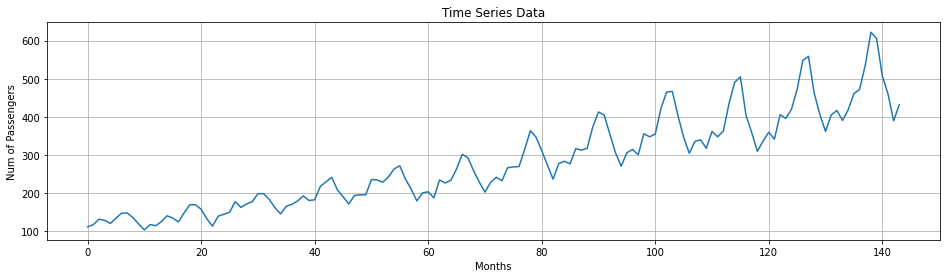

In [ ]:
data = sns.load_dataset("flights")

plt.figure(figsize=(16,4))
plt.title("Time Series Data");
plt.plot(data['passengers'])
plt.xlabel('Months')
plt.ylabel('Num of Passengers')
plt.grid()

 ## **MinMax scaling and split dataset into training and test set**

 ##### All data points in the dataset before the date '1956-12' should be training set and all datapoints on the date and after should be part of test set.

##### Remove the 'Month' column from the datatset as it is not needed after this point.

##### The final name of the training and test sets must be train_X and test_X (**Note: This is required for the proper working of the subsequent cells.**)

In [ ]:
scaler = MinMaxScaler()
data[['passengers']] = scaler.fit_transform(data[['passengers']])

train_X = data[data['year']<1957]
test_X  = data[data['year']>=1957]

## **Generate sequences and the corresponding labels for both training and test set**

In [ ]:
sequence_length = 10
n_steps=20
col1 = "month"
col2 = "passengers"

# Function to create sequences
def gen1(id_df, seq_length, seq_cols):
  samples = list()
  data_array = id_df[seq_cols].values
  num_elements = data_array.shape[0]
  for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
    samples.append(data_array[start:stop, :])
  dat = np.array(samples)
  dat = dat.reshape((len(samples), seq_length, 1))
  return dat

# create X_train and Y_train
seq_array = gen1(train_X, sequence_length + n_steps, [col2])
X_train = seq_array[:, :sequence_length]
Y_train = np.empty((X_train.shape[0], sequence_length, n_steps))
for step_ahead in range(1, n_steps + 1):
    Y_train[..., step_ahead - 1] = seq_array[..., step_ahead:step_ahead + sequence_length, 0]

# create X_test and Y_test
seq_array1 = gen1(test_X, sequence_length + n_steps, [col2])
X_test = seq_array1[:, :sequence_length]
Y_test = np.empty((X_test.shape[0], sequence_length, n_steps))
for step_ahead in range(1, n_steps + 1):
    Y_test[..., step_ahead - 1] = seq_array1[..., step_ahead:step_ahead + sequence_length, 0]


# final training sequence 
print(X_train.shape, Y_train.shape)

# final test sequence
print(X_test.shape, Y_test.shape)

# Create first test sequence to be used to test each of the models below
X_new, Y_new = X_test[0:1], Y_test[0:1]
print(X_new.shape, Y_new.shape)

(66, 10, 1) (66, 10, 20)
(18, 10, 1) (18, 10, 20)
(1, 10, 1) (1, 10, 20)


## **Define function to plot training and validation loss**

In [ ]:
def plot_training_validation_loss(history, xlim=None, ylim=None, xint=None, yint=None):

  fig, ax = plt.subplots(figsize=(12,4))
  ax.set_title("Training and Validation Loss")
  ax.plot(history.history['loss'], label="Training loss", marker='o', markersize=3, color='blue')
  ax.plot(history.history['val_loss'], label="Validation loss", marker='o', markersize=3, color='red')

  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend(loc="upper right", prop={'size': 12})

  if xlim is not None:
    ax.set_xlim(xlim)
  if ylim is not None:
    ax.set_ylim(ylim)
  
  if xint is not None:
    start_x, end_x = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start_x, end_x + xint, xint))

  if yint is not None:
    start_y, end_y = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start_y, end_y + yint, yint))

  plt.grid()
  fig.tight_layout()
  plt.show();

## **Define function to plot the time series predictions**

In [ ]:
def plot_true_predicted_forecast(preds):

  plt.figure(figsize=(12,4));
  #print(X_new.reshape(sequence_length))
  plt.title("Predicted Time Series")

  input_seen_by_model = scaler.inverse_transform( X_new.reshape(sequence_length,1) ).reshape(sequence_length)
  actual              = scaler.inverse_transform( Y_new.reshape(sequence_length*n_steps)[-1*n_steps:].reshape(n_steps,1) ).reshape(n_steps)
  predicted           = scaler.inverse_transform( preds.reshape(sequence_length*n_steps)[-1*n_steps:].reshape(n_steps,1) ).reshape(n_steps)

  plt.plot( [i for i in range(sequence_length)] ,         input_seen_by_model )
  plt.plot( [i+sequence_length for i in range(n_steps)] , actual,     label='Actual', color='red')
  plt.plot( [i+sequence_length for i in range(n_steps)] , predicted, label='Predicted', color='blue') 

  plt.xlabel('Month')
  plt.ylabel('Passengers') 
  plt.grid()
  plt.legend()


# **RNN model to predict 10 steps in the future (n_steps=10)**

##### Construct a simple RNN model with 2 hidden layers and 4 nodes per layer. An output layer with 'n_steps' number of nodes.

##### Print the model summary.

In [ ]:
# seed for the n_steps = 10
np.random.seed(68)
tf.random.set_seed(68)

modelRNN1 = Sequential([ SimpleRNN(units=4, activation='relu', return_sequences=True, input_shape =(sequence_length,1)),
                         SimpleRNN(units=4, activation='relu', return_sequences=True),
                         Dense(units=n_steps)       ])
print(modelRNN1.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 10, 4)             24        
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 10, 4)             36        
_________________________________________________________________
dense_10 (Dense)             (None, 10, 20)            100       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
modelRNN1.compile(optimizer='adam', loss='mse')

historyRNN1 = modelRNN1.fit( x=X_train, y=Y_train, validation_data=(X_test,Y_test), epochs=300, batch_size=1) 

##### Use model.predict to predict test data.

##### Plot the test prediction and true values together for the **first sequence** in test set to compare the performance of the model to the actual output.

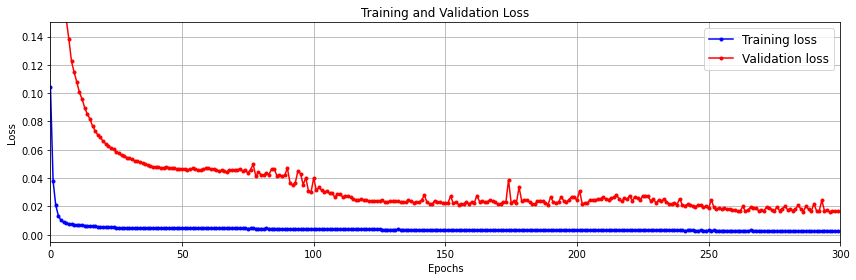

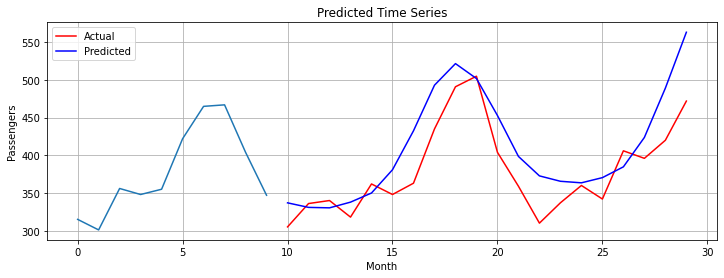

In [ ]:
# Plot training and validation loss
plot_training_validation_loss(historyRNN1, xlim=[0, 300],ylim=[-0.005, 0.15])

# Plot predicted result
Y_pred = modelRNN1.predict(X_new)
plot_true_predicted_forecast(Y_pred)

# **RNN model to predict 20 steps in the future (n_steps=20)**

##### Construct a simple RNN model with 2 hidden layers and 4 nodes per layer. An output layer with 'n_steps' number of nodes.

##### Print the model summary.

In [ ]:
# seed for the n_steps = 20
np.random.seed(75)
tf.random.set_seed(75)

modelRNN2 = Sequential([ SimpleRNN(units=4, activation='relu', return_sequences=True, input_shape =(sequence_length,1)),
                         SimpleRNN(units=4, activation='relu', return_sequences=True),
                         Dense(units=n_steps)       ])
print(modelRNN2.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 10, 4)             24        
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 10, 4)             36        
_________________________________________________________________
dense_11 (Dense)             (None, 10, 20)            100       
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
modelRNN2.compile(optimizer='adam', loss='mse')

historyRNN2 = modelRNN2.fit( x=X_train, y=Y_train, validation_data=(X_test,Y_test), epochs=300, batch_size=1 ) 

##### Use model.predict to predict test data.

##### Plot the test prediction and true values together for the **first sequence** in test set to compare the performance of the model to the actual output.

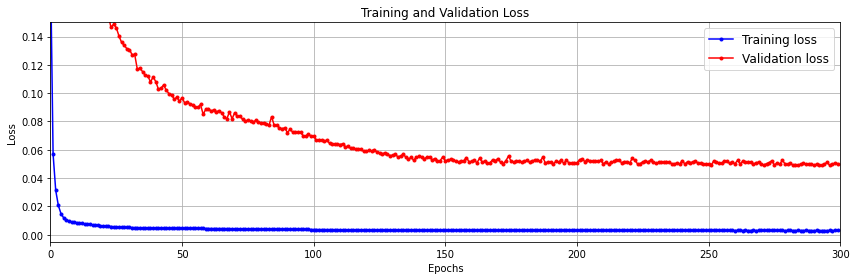

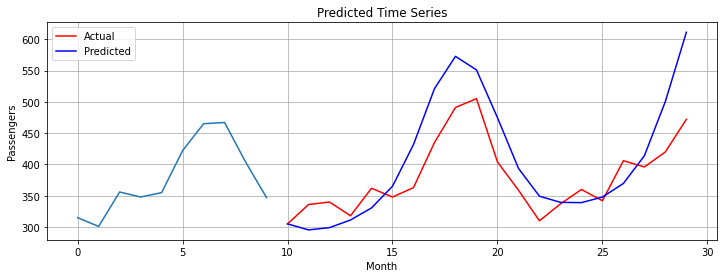

In [ ]:
# Plot training and validation loss
plot_training_validation_loss(historyRNN2, xlim=[0, 300], ylim=[-0.005, 0.15])

# Plot predicted result
Y_pred = modelRNN2.predict(X_new)
plot_true_predicted_forecast(Y_pred)

# **LSTM model to predict 20 steps in the future (n_steps=20)**


##### Construct a LSTM model with 2 hidden layers and 4 nodes per layer. An output layer with 'n_steps' number of nodes.

##### Print the model summary.

In [ ]:
# seed for the n_steps = 20
tf.random.set_seed(68)

modelLSTM1 = Sequential([ LSTM(units=4,activation='relu', return_sequences=True, input_shape=(sequence_length,1)),
                          LSTM(units=4,activation='relu', return_sequences=True),
                          Dense(units=n_steps) ])
modelLSTM1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10, 4)             96        
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 4)             144       
_________________________________________________________________
dense_9 (Dense)              (None, 10, 20)            100       
Total params: 340
Trainable params: 340
Non-trainable params: 0
_________________________________________________________________


##### Use model.predict to predict test data.

##### Plot the test prediction and true values together for the **first sequence** in test set to compare the performance of the model to the actual output.

In [ ]:
modelLSTM1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

historyLSTM1 = modelLSTM1.fit(x=X_train, y=Y_train, validation_data=(X_test,Y_test),epochs=300, batch_size=1)

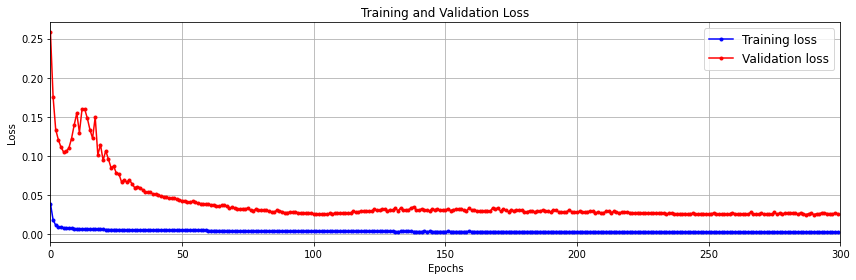

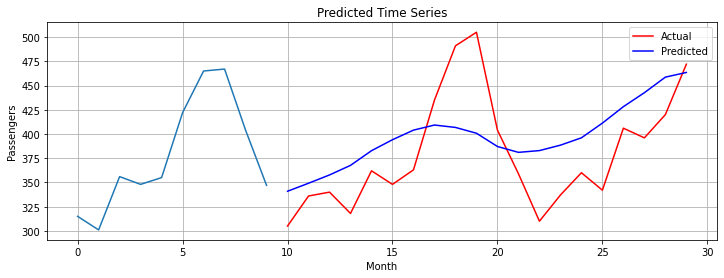

In [ ]:
# Plot training and validation loss
plot_training_validation_loss(historyLSTM1, xlim=[0, 300])

# Plot the test prediction and true values together for the first sequence in test set to compare the performance of the model to the actual output.
Y_pred = modelLSTM1.predict(X_new)
plot_true_predicted_forecast(Y_pred)